In [3]:
# IMPORTS
# import sys
# sys.path.insert(0, '../Analysis')
import helpers as h
import empatica_helpers as eh
import inquisit_helpers as ih
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import pickle

# ML IMPORTS
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

reload(h), reload(eh), reload(ih)

# GLOBAL SETTINGS
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:.2f}'.format
plt.rcParams["figure.figsize"] = (20, 10)
plt.style.use('seaborn-v0_8-notebook') # plt.style.use('ggplot'); print(plt.style.available)
pd.set_option('display.max_columns', None)

sr = 32
wl = 24 # Window length in seconds

# FULL PIPELINE
# e_raw, _ = eh.load_empatica(data_folder='input/empatica/', useIBI=False, save=True, plotTrimmings=False, desired_sampling_rate=sr)
# i_raw = ih.load_inquisit(data_folder='input/inquisit/', save=True)
# ei_raw = h.combine_empatica_and_inquisit(e_raw, i_raw, save=True, sr=sr)
# ei_prep = h.clean_and_filter(save=True, normalise=None, sr=sr, window_length=wl)
# X, y, p = h.prepare_for_vae(sr=sr, wl=wl, filepath="output/ei_prep_original.csv", save=True, normalise=None) # Normalisation now happens later in the process. Normalise = False applies the standard scaler to the data.
X_train, X_val, X_test, y_train, y_val, y_test, p_train, p_val, p_test = h.prepare_train_val_test_sets(filenames=['output/dl_X_wl24_sr32_original.pkl', 'output/dl_y_wl24_sr32_original.pkl', 'output/dl_p_wl24_sr32_original.pkl'])
X_train, X_val, X_test = h.handle_outliers_and_impute(X_train, X_val, X_test, num_mad=4, verbose=True)
X_train, X_val, X_test = h.scale_features(X_train, X_val, X_test, p_train, p_val, p_test, normalise=True)

# BACK TO INPUTS FOR ML MODELS
# X_train_aggregates = h.prepare_for_ml(X_train)
# X_val_aggregates = h.prepare_for_ml(X_val)
# X_test_aggregates = h.prepare_for_ml(X_test)

Train size:  80.23809523809524
Val size:  8.333333333333332
Test size:  11.428571428571429
Size: : (1011, 768, 6)
Initial imputation complete.
Missing values before outlier detection:
   Train  Validation  Test
0   0.00        0.00  0.00


/Users/koenraijer/Documents/00_Werk/Data_science/Thesis/Analysis/helpers.py:746: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outliers_df = pd.concat([outliers_df, pd.DataFrame({


Final imputation complete.
  Feature  Train  Validation  Test
0       0   0.59        0.00  0.00
1       1  15.58       14.62  6.23
2       2  10.81        0.00  0.00
3       3  11.32       15.51 13.71
4       4  13.67        0.00  0.00
5       5  23.94        9.54 13.29


## Evaluating statistical similarity between real and synthetic samples
- Options are: MANOVA and Wilks' Lambda. 
- Test multivariate normality using Mardia's tests.
- Test homogeneity of variances and covariances using Box's M test. 
- Independence of observations 
- If assumptions aren't met, we can use non-parametric tests like the multivariate analogue of the Mann-Whitney U test: the Kruskal-Wallis test by ranks. 

In [4]:
# Take the mean of each feature per sample
X_train_mean = np.mean(X_train, axis=1)

# Split along the decision class
X_train_0 = X_train_mean[y_train == 0]
X_train_1 = X_train_mean[y_train == 1]

# Split in half to create "real" and "synthetic" samples per decision class
X_train_0_synt = X_train_0[:len(X_train_0) // 2]
X_train_0_real = X_train_0[len(X_train_0) // 2:]

X_train_1_synt = X_train_1[:len(X_train_1) // 2]
X_train_1_real = X_train_1[len(X_train_1) // 2:]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


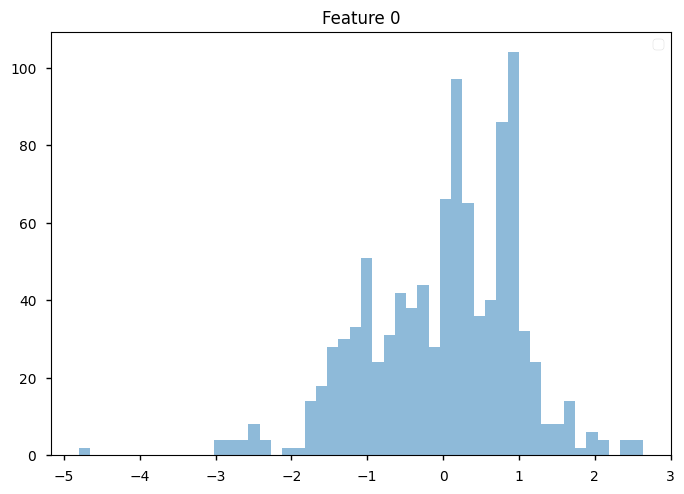

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


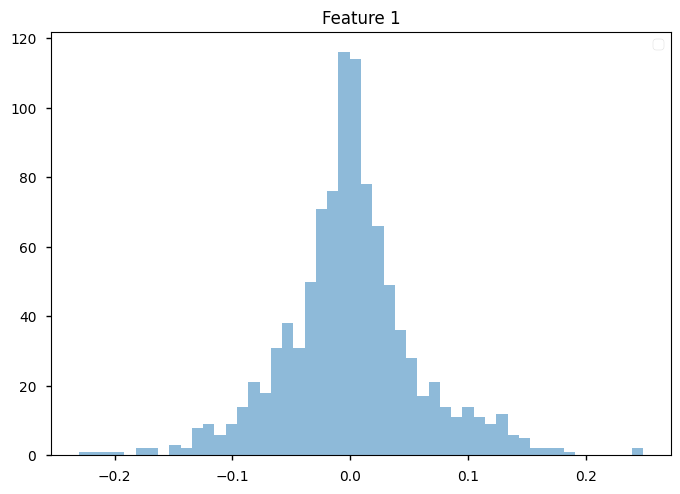

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


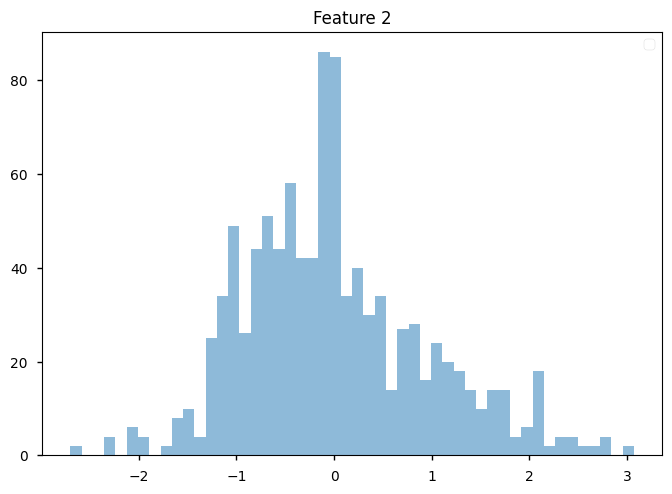

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


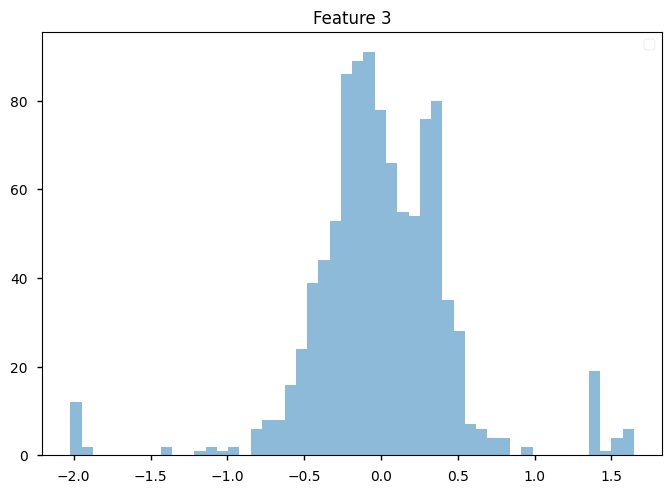

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


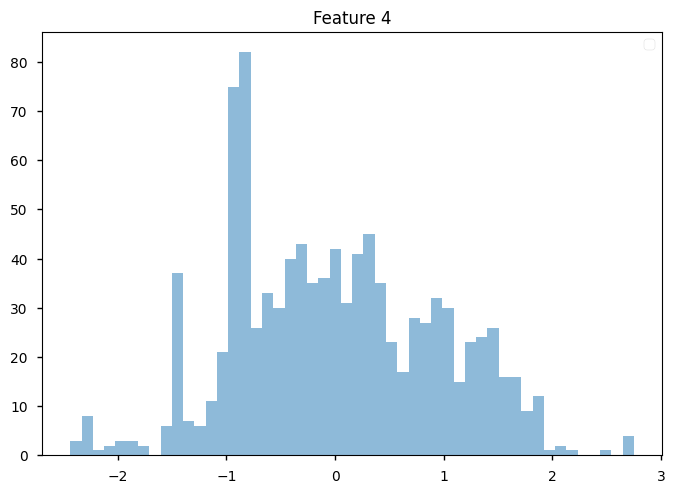

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


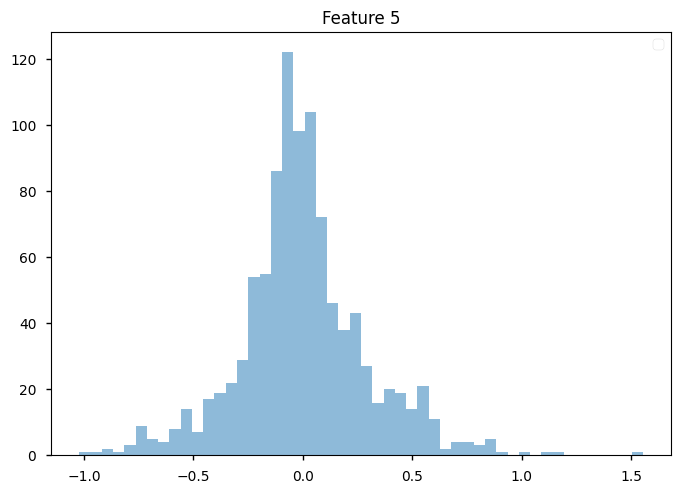

In [6]:
from pingouin import multivariate_normality

# print(multivariate_normality(X_train_0_synt, alpha=0.05))
# print(multivariate_normality(X_train_0_real, alpha=0.05))
# print(multivariate_normality(X_train_1_synt, alpha=0.05))
# print(multivariate_normality(X_train_1_real, alpha=0.05))

# Plot the distributions per feature
for i in range(X_train_mean.shape[1]):
    plt.figure()
    plt.hist(X_train_mean[:, i], bins=50, alpha=0.5)
    plt.legend()
    plt.title(f'Feature {i}')
    plt.show()

## Non-parametric multivariate significance testing
- Multivariate Kruskal-Wallis test has no known implementation in Python
- It is possible to do a univariate Kruskal-Wallis with post-hoc [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction)

In [5]:
from statsmodels.stats.multitest import multipletests
from scipy.stats.mstats import kruskalwallis

# Perform Kruskal-Wallis test for each feature per decision class
p_values_0 = []
H_values_0 = []

p_values_1 = []
H_values_1 = []

for i in range(X_train_0_synt.shape[1]):
    H, p = kruskalwallis(X_train_0_synt[:, i], X_train_0_real[:, i])
    p_values_0.append(p)
    H_values_0.append(H)

    H, p = kruskalwallis(X_train_1_synt[:, i], X_train_1_real[:, i])
    p_values_1.append(p)
    H_values_1.append(H)

# Correct for multiple comparisons
p_values_0_corr = multipletests(p_values_0, method='fdr_bh')[1]
p_values_1_corr = multipletests(p_values_1, method='fdr_bh')[1]

print("Class 0")
print("Original: ", p_values_0)
print("Corrected: ", p_values_0_corr)

print("Class 1:")
print("Original: ", p_values_1)
print("Corrected: ", p_values_1_corr)

Class 0
Original:  [0.7457182452017806, 0.8275980359592321, 0.9334881152915513, 0.3448352626703858, 0.12173490908295706, 0.06369103262887095]
Corrected:  [0.93348812 0.93348812 0.93348812 0.68967053 0.36520473 0.36520473]
Class 1:
Original:  [0.7638970079593081, 0.9152624746118548, 0.9946939484767684, 0.1124716175495755, 0.528262543736534, 0.33435094329779247]
Corrected:  [0.99469395 0.99469395 0.99469395 0.67482971 0.99469395 0.99469395]


## t-SNE (t-Distributed Stochastic Neighbor Embedding) 

t-SNE (t-Distributed Stochastic Neighbor Embedding) is a machine learning algorithm for visualization developed by Laurens van der Maaten and Geoffrey Hinton. It is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions.


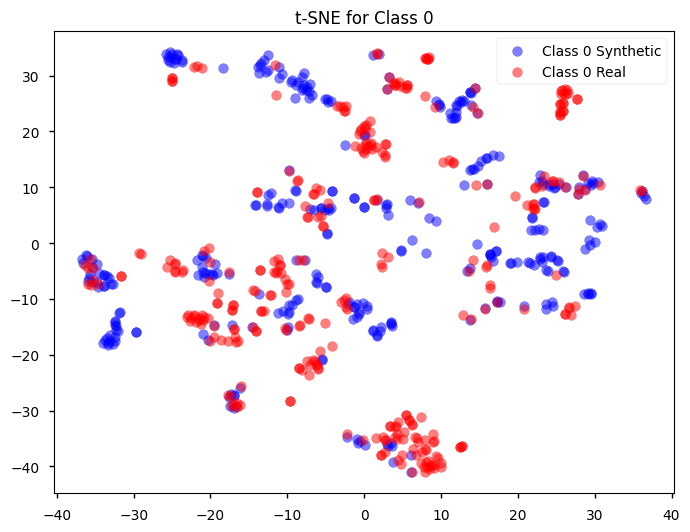

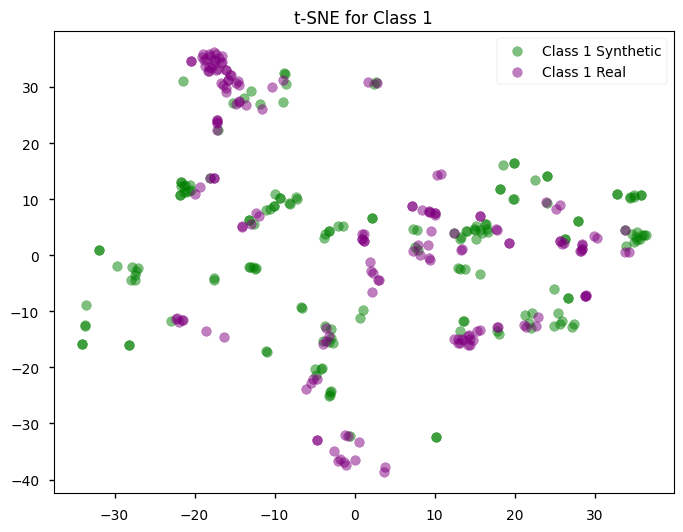

In [9]:
from sklearn.manifold import TSNE

X_all = np.concatenate([X_train_0_synt, X_train_0_real, X_train_1_synt, X_train_1_real])

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_mean)

# Plot the first two t-SNE components for class 0
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:len(X_train_0_synt), 0], X_tsne[:len(X_train_0_synt), 1], color='blue', alpha=0.5, label='Class 0 Synthetic')
plt.scatter(X_tsne[len(X_train_0_synt):len(X_train_0_synt)+len(X_train_0_real), 0], X_tsne[len(X_train_0_synt):len(X_train_0_synt)+len(X_train_0_real), 1], color='red', alpha=0.5, label='Class 0 Real')
plt.legend()
plt.title('t-SNE for Class 0')
plt.show()

# Plot the first two t-SNE components for class 1
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[len(X_train_0_synt)+len(X_train_0_real):len(X_train_0_synt)+len(X_train_0_real)+len(X_train_1_synt), 0], X_tsne[len(X_train_0_synt)+len(X_train_0_real):len(X_train_0_synt)+len(X_train_0_real)+len(X_train_1_synt), 1], color='green', alpha=0.5, label='Class 1 Synthetic')
plt.scatter(X_tsne[len(X_train_0_synt)+len(X_train_0_real)+len(X_train_1_synt):, 0], X_tsne[len(X_train_0_synt)+len(X_train_0_real)+len(X_train_1_synt):, 1], color='purple', alpha=0.5, label='Class 1 Real')
plt.legend()
plt.title('t-SNE for Class 1')
plt.show()

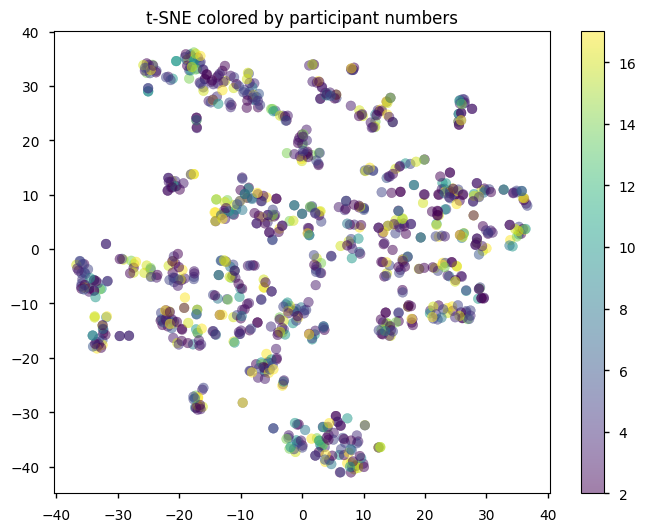

In [8]:
from sklearn.manifold import TSNE

X_train.shape # (n_samples, n_features)

# Perform t-SNE on X_train_mean
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_mean)

# Create a scatter plot
plt.figure(figsize=(8, 6))

# Use p_train for coloring
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=p_train, alpha=0.5)

# Add a color bar
plt.colorbar(scatter)

plt.title('t-SNE colored by participant numbers')
plt.show()

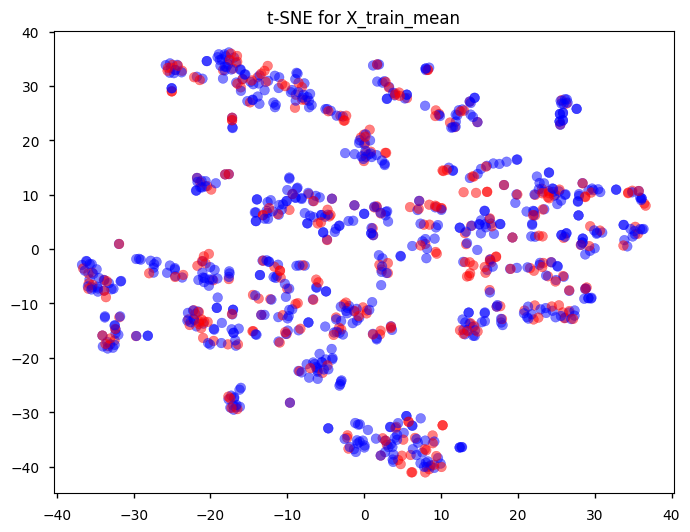

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_mean)

# Create a color map for y_train
colors = ['blue' if label == 0 else 'red' for label in y_train]

# Plot the t-SNE components with y_train as the color
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], color=colors, alpha=0.5)
plt.title('t-SNE for X_train_mean')
plt.show()